In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
from customDataset import FlowDataset  # Update the import path to match your actual directory structure
from FlowNetS import FlowNetS  # Replace with your actual model import

In [3]:
# Hyperparameters
batch_size = 1
learning_rate = 0.001
epochs = 10

In [4]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Initialize your custom dataset
dataset = FlowDataset(root_dir='C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset')

True


In [6]:
# Split the dataset into train and evaluation sets
X_train, X_eval = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)

In [7]:
# Create data loaders for training and evaluation
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=X_train)
eval_loader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=X_eval)

In [8]:
# Initialize the model
model = FlowNetS()  # Replace with your model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on {device}")

Model loaded on cpu


In [9]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Adjust the loss function as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
import numpy as np

In [11]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        images, flow = batch
        print(np.shape(images))
        images, flow = images.to(device), flow.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        print(np.shape(flow))
        loss = torch.norm(outputs - flow, p=2, dim=1).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {average_loss:.4f}")

folder: backstep, number of images 3200
folder: cylinder, number of images 2050
torch.Size([1, 2, 256, 256])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
folder: backstep, number of images 3200
torch.Size([1, 2, 256, 256])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
folder: backstep, number of images 3200
folder: cylinder, number of images 2050
torch.Size([1, 2, 256, 256])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
folder: backstep, number of images 3200
torch.Size([1, 2, 256, 256])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
folder: backstep, number of images 3200
folder: cylinder, number

KeyboardInterrupt: 

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        images, flow = batch
        images, flow = images.to(device), flow.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, flow)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {average_loss:.4f}")

In [ ]:
# Save the trained model if needed
torch.save(model.state_dict(), 'trained_model.pth')

____

In [12]:
x, y = next(iter(train_loader))
print(np.shape(x))
print(np.shape(y))

folder: backstep, number of images 3200
folder: cylinder, number of images 2050
torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])


In [13]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Velocity Field')

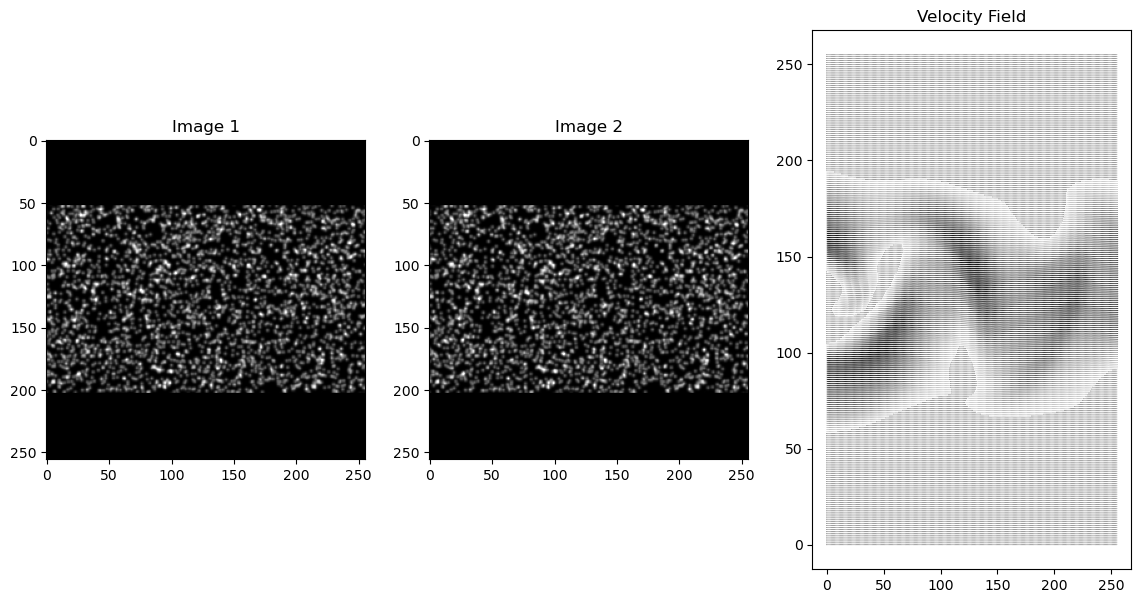

In [14]:
import numpy as np

fig = plt.figure(figsize=(14,7))
# Plot the velocity field using quiver plot
# Visualize the first image in the pair
plt.subplot(1, 3, 1)
plt.imshow(x[0, 0, :, :], cmap='gray')
plt.title('Image 1')

# Visualize the second image in the pair
plt.subplot(1, 3, 2)
plt.imshow(x[0, 1, :, :], cmap='gray')
plt.title('Image 2')

plt.subplot(1, 3, 3)
#y = np.resize(y, (1,256, 256,2))
#plt.quiver(y[0, :, :, 0], y[0, :, :, 1])
plt.quiver(y[0, 0, :, :], y[0, 1, :, :])
plt.title('Velocity Field')

In [ ]:
# Plot the velocity field using quiver plot
plt.subplot(133)
x, y = np.meshgrid(np.arange(0, 256, 16), np.arange(0, 256, 16))  # Sample points for quiver plot
u = velocity_field[::16, ::16, 0]
v = velocity_field[::16, ::16, 1]
plt.quiver(x, y, u, v, color='r', angles='xy', scale_units='xy', scale=1)
plt.title('Velocity Field')

plt.tight_layout()
plt.show()

tensor(49732)